# Heterogeneous Ensembles
The obvious way to produce an ensemble of diverse classifiers is to use different model types as the base estimators.  
The `VotingEnsemble` is `scikit-learn` is designed to do this.
 1. We assess the performance of a classifier ensemble with 7 different estimators, *k*-NN, Logisitc Regression, D-Tree, Artificial Neural Net, Support Vector Classifier, Quadraitic Discriminant Analysis and Naive Bayes. 
 2. We measure diversity using the plain disagreement measure.
 3. We compare this with the performance of a Bagging ensemble with 7 members.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.pipeline import make_pipeline

### Load Data

In [2]:
hotel_pd = pd.read_csv('HotelRevHelpfulness.csv')
hotel_pd.head()

,hotelId,aveHelpfulnessRatioUser,stdevHelpfulnessRatioUser,pcReviewsExceedMinHelpfulnessSupport,numReviewsUser,numReviewsHotel,ratingUser,numberSubRatingsUser,subRatingMeanUser,subRatingStdevUser,...,completeness_2,completeness_3,numberTermsEntry,percentageAlphaCharsEntry,fractionUpperCaseCharsEntry,fractionYouVsIEntry,numberTermsSummaryQuote,percentageAlphaCharsSummaryQuote,fractionUpperCaseCharsSummaryQuote,reviewHelpfulness
0,17420,1.000000,0.000000,0.666667,3,16,5,4,4.000000,0.000000,...,0,1,182,0.788474,0.025703,0.500000,6,0.815789,0.096774,1
1,1397,0.772487,0.377321,0.500000,12,233,5,0,0.000000,0.000000,...,0,0,158,0.791888,0.012594,0.500000,1,1.000000,0.083333,1
2,1348,0.715473,0.300437,0.833333,12,302,4,7,3.714286,0.755929,...,0,3,59,0.799639,0.024831,0.333333,4,0.828571,0.034483,0
3,5940,0.521250,0.481675,0.222222,36,6,1,4,1.000000,0.000000,...,0,0,95,0.782212,0.029155,0.500000,2,0.800000,0.062500,0
4,38,0.603175,0.246926,1.000000,2,271,3,0,0.000000,0.000000,...,0,0,43,0.805128,0.028662,0.000000,1,1.000000,0.142857,0


In [3]:
hotel_pd.pop('hotelId').values
y = hotel_pd.pop('reviewHelpfulness').values
X = hotel_pd.values
X.shape

(486, 23)

## Heterogenous Ensemble

Data needs to be scaled for most of the models.

In [4]:
scaler = StandardScaler()
ann = make_pipeline(scaler, MLPClassifier(solver='lbfgs'))
lr = make_pipeline(scaler, LogisticRegression())
kNN = make_pipeline(scaler, KNeighborsClassifier(n_neighbors=3))
dtree = DecisionTreeClassifier(criterion='entropy')
gnb = make_pipeline(scaler, GaussianNB())
svc = make_pipeline(scaler, SVC(probability=True))
qda = make_pipeline(scaler, QuadraticDiscriminantAnalysis())

Set up the list of estimator tuples.  
This data structure is passed to the `scikit-learn` `VotingClassifer`. 


In [5]:
estimator_tups = [('k-NN',kNN),('Tree', dtree),('Naive Bayes',gnb),
                  ('Ann',ann), ('Logistic',lr), ('SVC', svc), ('QDA', qda)]

Set up the voting classifier with the seven estimators and fit it on the training data.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, 
                                                    random_state = 42)
voting = VotingClassifier(estimators=estimator_tups, voting = 'hard')
voting.fit(X_train,y_train)
voting.estimators_

[Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier(n_neighbors=3))]),
 DecisionTreeClassifier(criterion='entropy'),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gaussiannb', GaussianNB())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('mlpclassifier', MLPClassifier(solver='lbfgs'))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression', LogisticRegression())]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc', SVC(probability=True))]),
 Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('quadraticdiscriminantanalysis',
                  QuadraticDiscriminantAnalysis())])]

In [7]:
model_names = [x[0] for x in estimator_tups]
model_names

['k-NN', 'Tree', 'Naive Bayes', 'Ann', 'Logistic', 'SVC', 'QDA']

In order to produce estimates of diversity/disagreement between the estimators we produce predictions for all estimators on the test data.

In [8]:
res_df = pd.DataFrame()
model_names = [x[0] for x in estimator_tups]
for name, clf in zip(model_names,voting.estimators_):
    y_preds = clf.predict(X_test)
    res_df[name]=y_preds
res_df.head()

,k-NN,Tree,Naive Bayes,Ann,Logistic,SVC,QDA
0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1
3,0,1,0,1,0,1,0
4,1,1,0,1,0,1,1


A function to return a count of the entries in lists `l1` and `l2` that are not equal.  
This is the *plain disagreement* measure to quantify ensemble diversity. 

In [9]:
def plain_dis(l1, l2):
    m = len(l1)
    count = 0
    for i, j in zip(l1,l2):
        if i != j:
            count += 1
    return count/m

In [10]:
print('%4.3f' % (plain_dis(res_df['k-NN'],res_df['Tree'])))
print('%4.3f' % (plain_dis(res_df['Naive Bayes'],res_df['Tree'])))
print('%4.3f' % (plain_dis(res_df['Naive Bayes'],res_df['k-NN'])))

0.354
0.354
0.369


Calculate the plain disagreement scores for the 7 estimators.

In [11]:
N = len(model_names)
plain_dis_arr = np.zeros((N,N))

for i_ind,i in enumerate(model_names):
    for j_ind,j in enumerate(model_names):
        plain_dis_arr[i_ind,j_ind] = plain_dis(res_df[i],res_df[j])
plain_dis_arr.max()

0.4153846153846154

### Heterogeneous Ensemble Predictions

In [12]:
res_df['Actual'] = y_test
res_df['Voting'] = voting.predict(X_test)
res_df

,k-NN,Tree,Naive Bayes,Ann,Logistic,SVC,QDA,Actual,Voting
0,0,1,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,0,0
2,0,1,0,1,0,0,1,1,0
3,0,1,0,1,0,1,0,1,0
4,1,1,0,1,0,1,1,1,1
...,...,...,...,...,...,...,...,...,...
190,1,0,0,0,1,1,0,0,0
191,1,1,0,1,1,1,1,0,1
192,0,0,1,1,0,1,1,1,1
193,1,1,1,1,1,1,1,0,1


In [13]:
model_acc = []
for m in model_names:
    acc = accuracy_score(res_df['Actual'],res_df[m])
    model_acc.append(acc)
    print(m, '%4.3f' % acc)
    
c_acc = accuracy_score(res_df['Actual'],res_df['Voting'])
model_acc.append(c_acc)
print('Voting %4.3f' % c_acc)

k-NN 0.641
Tree 0.605
Naive Bayes 0.631
Ann 0.656
Logistic 0.723
SVC 0.708
QDA 0.682
Voting 0.718


## Bagging
Ensembles based on Bagging. 
- 7 ensemble members are trained using bootstrap resampling

We don't need to worry about scaling here because the base estimator is a tree. 

In [14]:
tree_bag = BaggingClassifier(dtree, 
                            n_estimators = 7,
                            max_samples = 1.0, # bootstrap resampling 
                            bootstrap = True)

The 7 members of the bagging ensemble trained on bootstrap samples from `X_train`

In [15]:
bag_ests = tree_bag.fit(X_train,y_train).estimators_

In [16]:
bag_df = pd.DataFrame()
for i, est in enumerate(bag_ests):
    y_preds = est.predict(X_test)
    bag_df['Est '+ str(i+1)]=y_preds

In [17]:
bag_df['Actual'] = y_test
bag_df['Bagging'] = tree_bag.predict(X_test)
bag_df.head()

,Est 1,Est 2,Est 3,Est 4,Est 5,Est 6,Est 7,Actual,Bagging
0,1,1,1,1,0,0,0,1,1
1,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,0,1,1,1
3,1,1,1,0,1,0,1,1,1
4,1,1,1,1,1,1,1,1,1


In [18]:
N = 7
bag_names = []
for i in range(N):
    bag_names.append('Est '+ str(i+1))

bag_dis_arr = np.zeros((N,N))

for i_ind,i in enumerate(bag_names):
    for j_ind,j in enumerate(bag_names):
        bag_dis_arr[i_ind,j_ind] = plain_dis(bag_df[i],bag_df[j])
bag_dis_arr.max()

0.4256410256410256

Find the largest diffence in the difference matrices.  
We use this later so that the two colour maps use the same colour scale. 

In [19]:
print('Max difference in Hetero Ensemble: %4.3f' % (plain_dis_arr.max()))
print('Max difference in Bagged Ensemble: %4.3f' % (bag_dis_arr.max()))
maxv = max(bag_dis_arr.max(),plain_dis_arr.max())
print('Overall max is: %4.3f' % maxv)

Max difference in Hetero Ensemble: 0.415
Max difference in Bagged Ensemble: 0.426
Overall max is: 0.426


In [20]:
bag_est_acc =[]
for i in range(N):
    ms = 'Est '+ str(i+1)
    acc = accuracy_score(bag_df['Actual'],bag_df[ms])
    print(ms, '%4.3f' % acc)
    bag_est_acc.append(acc)
bag_acc = accuracy_score(bag_df['Actual'],bag_df['Bagging'])
print('Bagging', '%4.3f' % bag_acc)
bag_est_acc.append(bag_acc)

Est 1 0.692
Est 2 0.667
Est 3 0.636
Est 4 0.615
Est 5 0.646
Est 6 0.621
Est 7 0.687
Bagging 0.723


## Plotting results
We look at the accuracies and the disagreement (diversity) among the ensemble members.   
We see that the diversity with bagging is just as good as with the heterogenous ensemble. 

In [21]:
# Function to plot colourmaps of the disagreement matrices.

def do_colourmap (matrix, names, title = ' ', **kwargs):
    if 'vmx' in kwargs:    # check that 'reps' is a keyword
        vmax_val = kwargs['vmx']
    else: vmax_val = matrix.max()

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(matrix, cmap = 'gray', vmax= vmax_val)
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(names)))
    ax.set_yticks(np.arange(len(names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(names)):
        for j in range(len(names)):
            text = ax.text(j, i, round(matrix[i, j],2),
                           ha="center", va="center", color="r")
    ax.set_title(title)
    fig.tight_layout()
    plt.show()
    return fig

`maxv` is the largest value in both arrays so colourmaps match. 

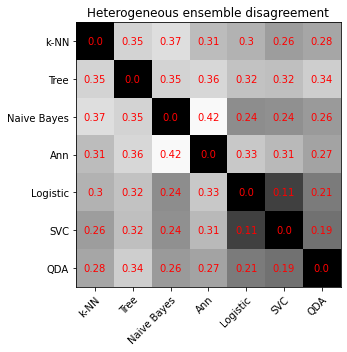

In [22]:
f = do_colourmap(plain_dis_arr, model_names, 
             title = 'Heterogeneous ensemble disagreement', vmx = maxv)
f.savefig('HeteroCM.pdf')

In [23]:
len(bag_names), bag_dis_arr.shape

(7, (7, 7))

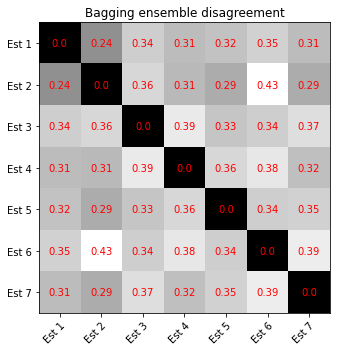

In [24]:
f = do_colourmap(bag_dis_arr, bag_names, 
             title = 'Bagging ensemble disagreement', vmx = maxv)
f.savefig('BagCM.pdf')

In [25]:
def simple_barchart(names, values, colours, title = ' ',
                    y_lab='', x_lab = '' , ymax = 1):
    y_pos = np.arange(len(names))
    fig = plt.figure(figsize=(7,4))
    plt.bar(y_pos, values, align='center', color = colours, alpha=0.5)
    plt.xticks(y_pos, names)
    plt.ylabel(y_lab)
    plt.xlabel(x_lab)
    plt.title(title)
    plt.ylim((0,ymax))
    plt.grid(axis = 'y')
    plt.show()
    return fig

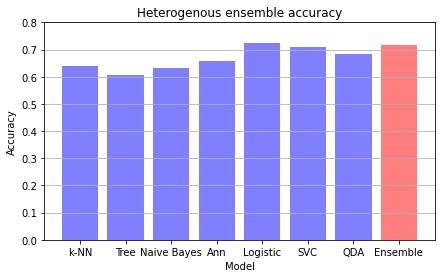

In [26]:
model_names.append('Ensemble')
clrs = ('b','b','b','b','b','b','b','r')
f = simple_barchart(model_names,model_acc,clrs, ymax = 0.8, title = 'Heterogenous ensemble accuracy',
                y_lab = 'Accuracy', x_lab = 'Model')
f.savefig('HeteroBars.pdf')

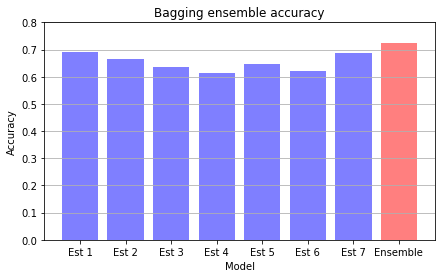

In [27]:
clrs = ('b','b','b','b','b','b','b','r')
f = simple_barchart(bag_names +['Ensemble'],bag_est_acc,clrs, ymax = 0.8,
                title = 'Bagging ensemble accuracy',
                y_lab = 'Accuracy', x_lab = 'Model')
f.savefig('BagBars.pdf')

## Cross Validation Test
A cross-validation test to show that the hold-out accuracy estimates for the heterogenous ensemble compared with the single estimators is not an outlier. 

Two of the estimators (SCV and Logistic) on their own are as good as the voting ensemble result. 

In [28]:
scores_dict = {}
rkf = RepeatedKFold(n_splits=10, n_repeats=20)
model_names = [x[0] for x in estimator_tups]
for name, clf in zip(model_names,voting.estimators_):
    score = cross_val_score(clf,X,y, cv = rkf, n_jobs = -1).mean()
    scores_dict[name] = score

In [29]:
for k in scores_dict.keys():
    print(' %11s % 4.3f' % (k, scores_dict[k]))
score = cross_val_score(voting,X,y, cv = rkf, n_jobs = -1).mean()
print(' %11s % 4.3f' % ('Voting', score))

        k-NN  0.637
        Tree  0.656
 Naive Bayes  0.653
         Ann  0.656
    Logistic  0.722
         SVC  0.717
         QDA  0.671
      Voting  0.711


In [32]:
score = cross_val_score(tree_bag,X,y, cv = rkf, n_jobs = -1).mean()
print(' %11s % 4.3f' % ('Bagging', score))

     Bagging  0.703
